vgg16 Face2sketch models code

In [23]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://youtu.be/bIaT2X5Hd5k
#Code adaptapted from this video

from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os

"""
Because we are going to replace the encoder part with VGG16, 
we don’t need it as a classifier, we need it as a feature extractor so, 
the last dense layers isn’t needed we have to pop them up.

here, we iterate on each layer except the last dense layers so, 
we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. 
we will be using that latent space volume as a feature vector to be input to the decoder.
 and the decoder is going to learn the mapping from the latent space vector to ab channels. 
 we want the layers of VGG16 with its original weights without changing them, 
 so that we set the trainable parameter in each layer to false because we don’t want to train them again.
"""
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()



Preprocessing

In [24]:
import cv2
from tqdm import tqdm 
import re
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 224

image_path = 'CUHK Dataset/CUHK_training_cropped_photos'
img_array = []

sketch_path = 'CUHK Dataset/CUHK_training_cropped_sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))

image_test_path = 'CUHK Dataset/CUHK_testing_cropped_photos'
image_test_file = sorted_alphanumeric(os.listdir(image_test_path))
img_test_array = []

for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))
    
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

train_sketch = sketch_array
train_image = img_array

for i in tqdm(image_test_file):
    image = cv2.imread(image_test_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    
    
    #appending normal normal image    
    img_test_array.append(img_to_array(image))
    # Image Augmentation

test_image = img_test_array

sketch_test_path = 'CUHK Dataset/CUHK_testing_cropped_sketches'
sketch_test_file = sorted_alphanumeric(os.listdir(sketch_test_path))
sketch_test_array = []

for i in tqdm(sketch_test_file):
    image = cv2.imread(sketch_test_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # normalizing image 
    image = image.astype('float32') / 255.0
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    
    
    #appending normal normal image    
    sketch_test_array.append(img_to_array(image))
    # Image Augmentation

test_sketch = sketch_test_array

100%|██████████| 88/88 [00:00<00:00, 595.76it/s]


Total number of sketch images: 704
Total number of images: 704


100%|██████████| 100/100 [00:00<00:00, 1854.22it/s]


VGG16 encoder

In [25]:
newmodel = Sequential()
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 

"""
VGG16 is expecting an image of 3 dimension with size 224x224 as an input, 
in preprocessing we have to scale all images to 224 instead of 256
"""

print(len(train_image)) 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

VGG16 create feature space

In [4]:
vggfeatures = []
for i in range(len(img_array)):
  sample = img_array[i]
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

Y = np.array(sketch_array)

1/1 [==============================] - 0s 150ms/step
(704, 7, 7, 512)


In [19]:
#Decoder 
model2 = Sequential()

model2.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(3, (3, 3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_26 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_27 (UpSamplin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)       

In [6]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

#Taken from:
#https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

Epoch 1/1000
6/6 [==============================] - 4s 604ms/step - loss: 3.1518 - accuracy: 0.4154 - val_loss: 0.1956 - val_accuracy: 0.1335
Epoch 2/1000
6/6 [==============================] - 4s 572ms/step - loss: 0.2257 - accuracy: 0.3055 - val_loss: 0.1666 - val_accuracy: 0.5590
Epoch 3/1000
6/6 [==============================] - 4s 569ms/step - loss: 0.1537 - accuracy: 0.3758 - val_loss: 0.1120 - val_accuracy: 0.4925
Epoch 4/1000
6/6 [==============================] - 4s 571ms/step - loss: 0.1105 - accuracy: 0.4351 - val_loss: 0.0910 - val_accuracy: 0.3319
Epoch 5/1000
6/6 [==============================] - 4s 589ms/step - loss: 0.0936 - accuracy: 0.3345 - val_loss: 0.0782 - val_accuracy: 0.3049
Epoch 6/1000
6/6 [==============================] - 4s 573ms/step - loss: 0.0850 - accuracy: 0.2947 - val_loss: 0.0716 - val_accuracy: 0.3097
Epoch 7/1000
6/6 [==============================] - 3s 570ms/step - loss: 0.0766 - accuracy: 0.3839 - val_loss: 0.0646 - val_accuracy: 0.2435
Epoch 

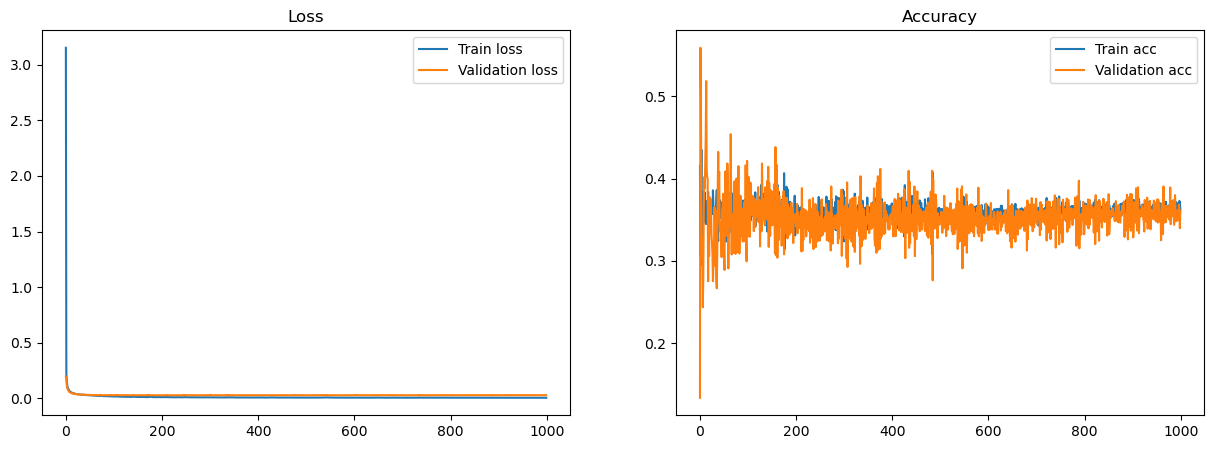

In [20]:

model2.compile(optimizer = 'adam', loss='mse' , metrics=['accuracy'])
history = model2.fit(vggfeatures, Y, verbose=1, epochs=1000, validation_split=0.1, batch_size=124)



show_final_history(history)

In [21]:
model2.save('VGG16_f2s_1000.model')

INFO:tensorflow:Assets written to: VGG16_f2s_1000.model/assets


INFO:tensorflow:Assets written to: VGG16_f2s_1000.model/assets


Test images:
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


Train images:
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


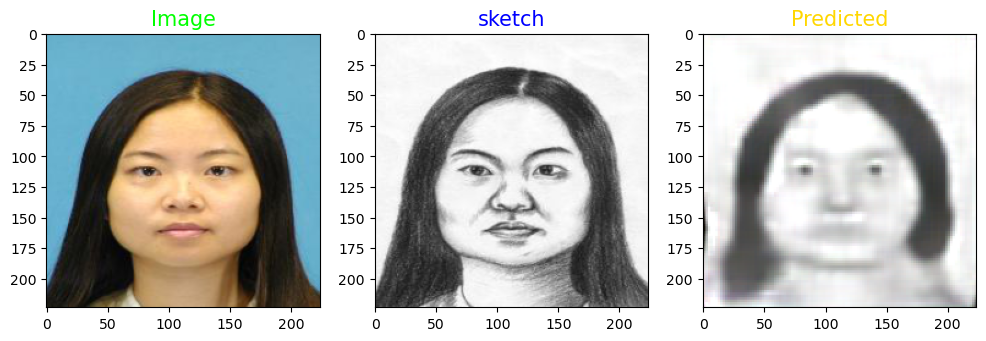

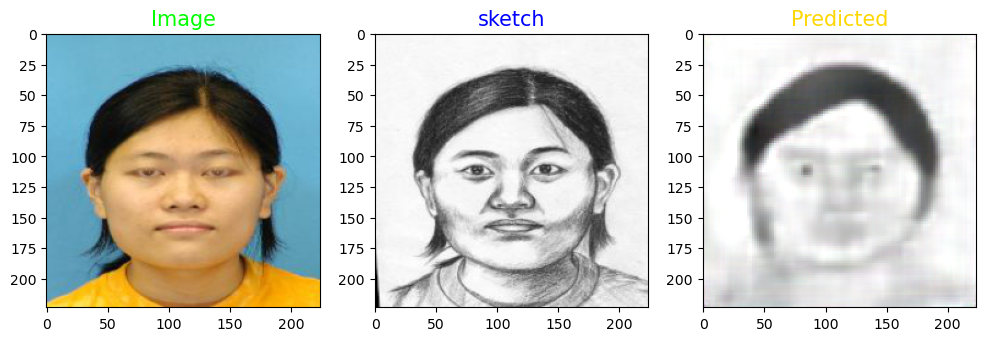

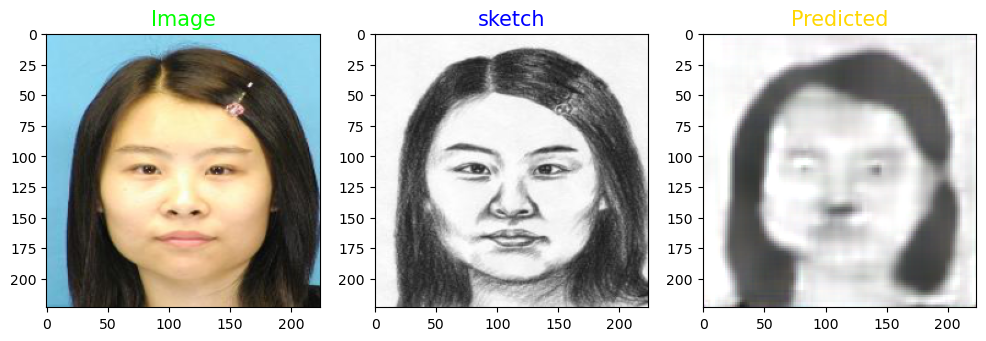

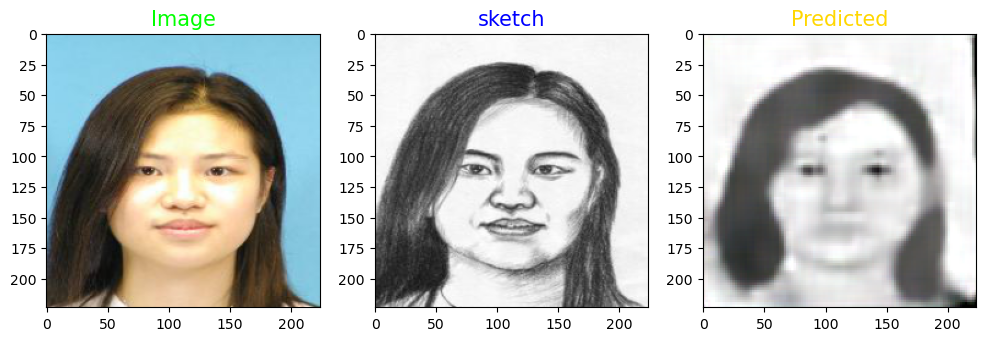

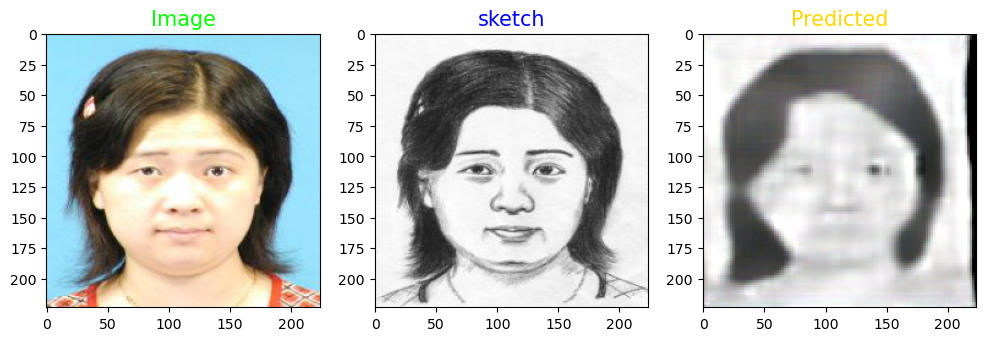

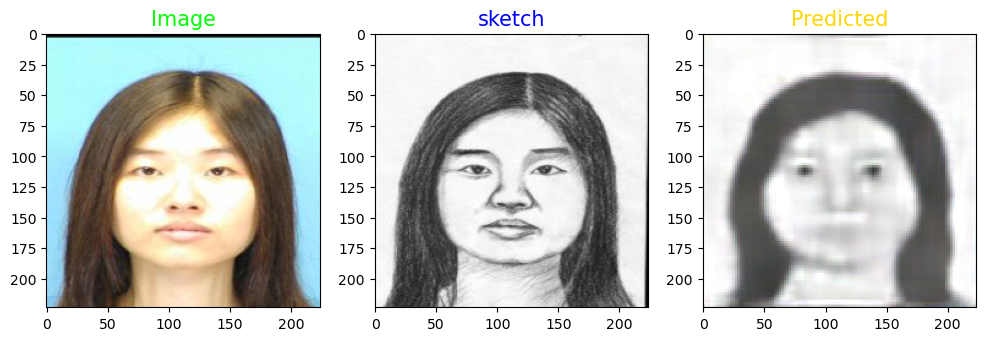

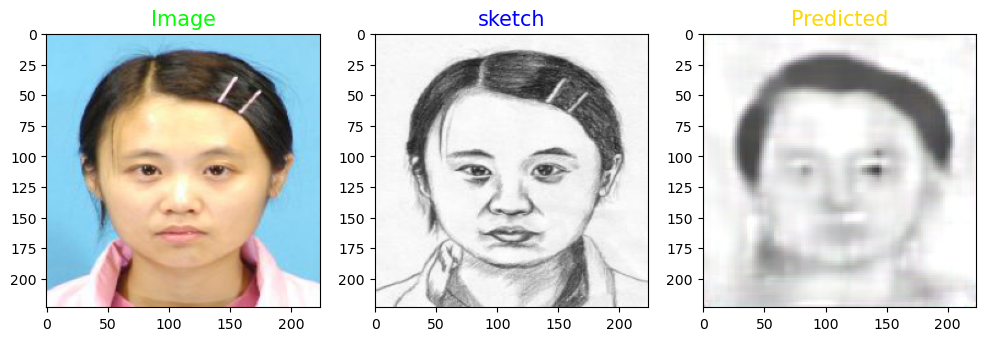

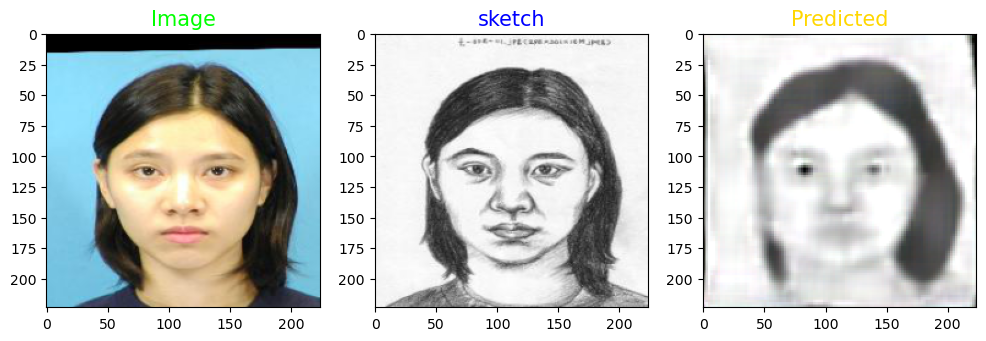

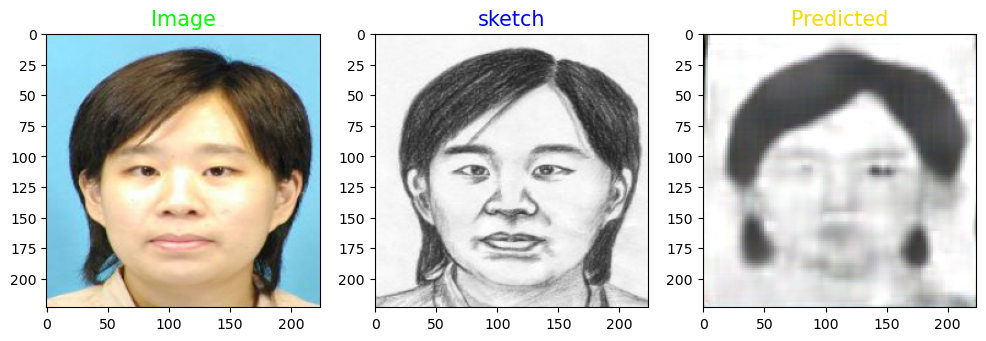

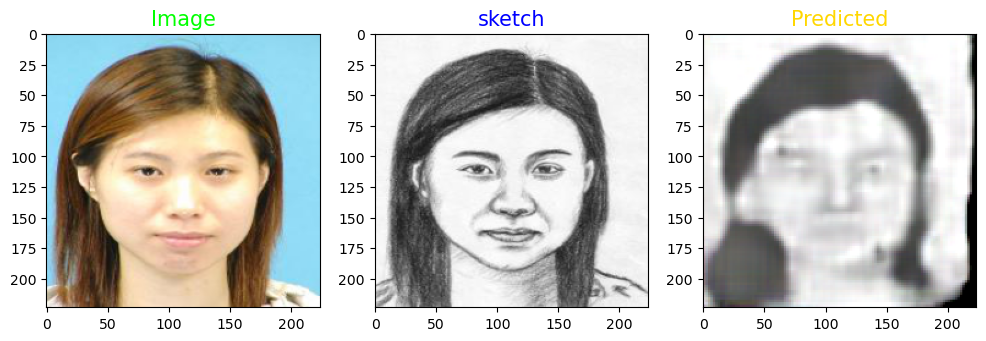

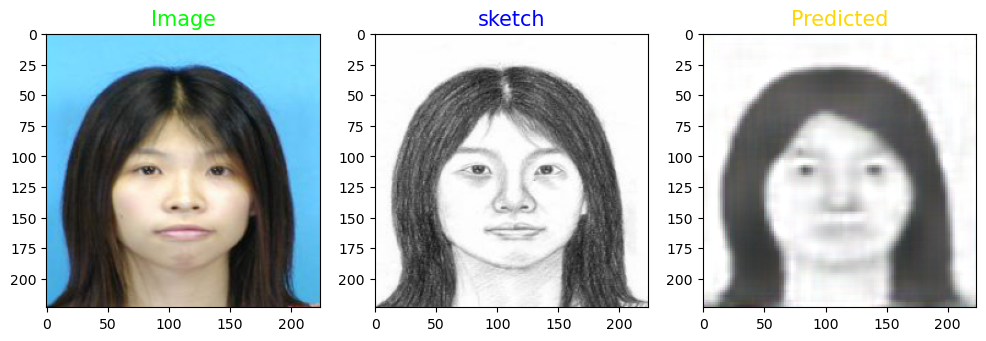

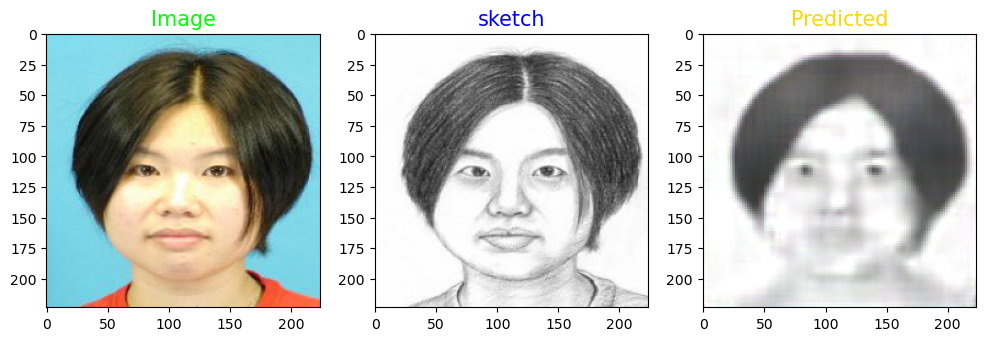

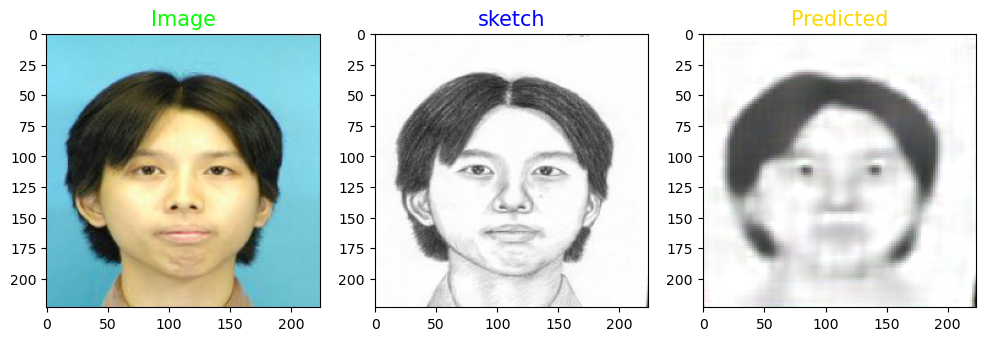

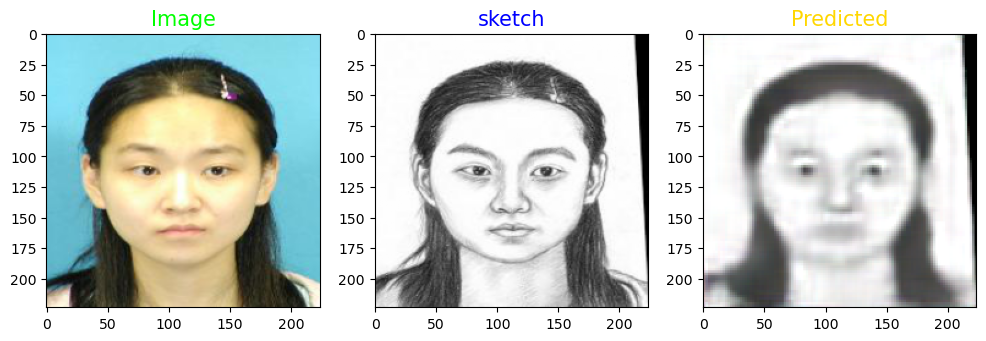

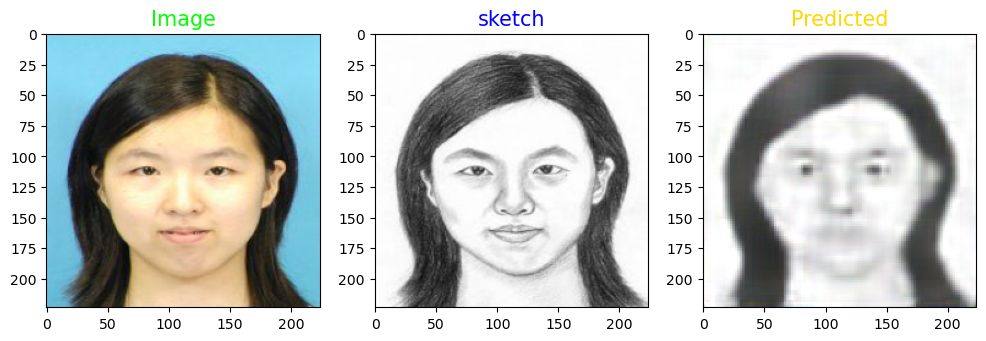

In [22]:
############################################
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)




print("Test images:")
for i in range(10):
    test_image_sample = test_image[i].reshape((1,224,224,3))
    vggpred = newmodel.predict(test_image_sample)
    sample_pred = model2.predict(vggpred).reshape((224,224,3))
    
    
    show_images(test_image[i],test_sketch[i],sample_pred)
print("Train images:")
for i in range(0,40,8):
    test_image_sample = train_image[i].reshape((1,224,224,3))
    vggpred = newmodel.predict(test_image_sample)
    sample_pred = model2.predict(vggpred).reshape((224,224,3))
    
    show_images(train_image[i],train_sketch[i],sample_pred)